In [575]:
import cv2
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

from src.camera import Camera
from src.utils.cube import generate_cube

In [589]:
def resize(frame):
    height, width, layers =  frame.shape
    frame = cv2.resize(frame, (int(width/2), int(height/2)))
    blured = blur = cv2.GaussianBlur(frame,(5,5),0)
    return frame, blured

In [590]:
cap = cv2.VideoCapture("videos/video13.mp4")
buffer = []
original_images_buffer = []
while(cap.isOpened()):
    ret, frame = cap.read()    
    if ret == True:
        frame, blured = resize(frame)
        buffer.append(frame)
        original_images_buffer.append(frame)
    else:
        cap.release()

In [591]:
def check_rotation_matrix(R):
    return abs(np.linalg.det(R)) - 1.0 < 1e-07 

In [592]:
class Feature(object):
    """ Image features """
    def __init__(self, points, keypoints, descriptors):
        self.points = points
        self.keypoints = keypoints
        self.descriptors = descriptors

In [593]:
def match_images(image_one, image_two):
    """ Match points between images

    Returns:
        f1, f2: features for image #1 and #2
    """
#     orb = cv2.ORB_create()

#     kp1, des1 = orb.detectAndCompute(image_one, None)
#     kp2, des2 = orb.detectAndCompute(image_two, None)

#     bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
#     matches = bf.match(des1, des2)
#     #matches = sorted(matches, key = lambda x: x.distance)
#     good = matches

    sift = cv2.xfeatures2d.SIFT_create()
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    kp1, des1 = sift.detectAndCompute(image_one, None)
    kp2, des2 = sift.detectAndCompute(image_two, None)

    matches = flann.knnMatch(des1, des2, k=2)

    good = []
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            good.append(m)

    pts1 = np.float64([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    pts2 = np.float64([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

    return Feature(pts1, kp1, des1), Feature(pts2, kp2, des2)

In [594]:
def find_homography_inliers(image_one, image_two):
    features1, features2 = match_images(image_one, image_two)
    M, mask = cv2.findHomography(features1.points, features2.points, cv2.RANSAC, 5.0)
    return np.count_nonzero(mask), np.count_nonzero(mask) / len(mask)

In [595]:
# min_pair, min_inliers_in_pair = None, 9999999.
# for i in range(len(buffer) - 1):
#     print("Intermediate result:", min_pair, min_inliers_in_pair)
#     for j in range(i + 1, len(buffer)):
#         _, ratio = find_homography_inliers(buffer[i], buffer[j])
#         #print(i, j, ratio)
#         if min_inliers_in_pair > ratio and ratio > 0.0:
#             min_pair = (i, j)
#             min_inliers_in_pair = ratio

# print("Result:", min_pair, min_inliers_in_pair)

In [596]:
img1, img2 = buffer[0], buffer[30]

features_1, features_2 = match_images(img1, img2)

E, mask = cv2.findEssentialMat(
    features_1.points, 
    features_2.points, 
    focal=1.0, 
    pp=(486.2, 265.59), 
    method=cv2.RANSAC, 
    prob=0.999, 
    threshold=1.0
)


points, R, t, mask = cv2.recoverPose(
    E, 
    features_1.points, 
    features_2.points, 
    focal=1.0,
    pp=(486.2, 265.59),
    mask=mask
)


K, dist = Camera().K, Camera().distortion 

camera1 = Camera.create(np.eye(3, 3), np.zeros((3, 1)))
camera2 = Camera.create(R, t)

undistorted_points_1 = cv2.undistortPoints(features_1.points, K, dist, R=np.eye(3, 3), P=camera1.get_projection_matrix())
undistorted_points_2 = cv2.undistortPoints(features_2.points, K, dist, R=R, P=camera2.get_projection_matrix())

points_3d_homog = cv2.triangulatePoints(
    camera1.get_projection_matrix(),
    camera2.get_projection_matrix(),
    undistorted_points_1,
    undistorted_points_2
)
points_3d = cv2.convertPointsFromHomogeneous(points_3d_homog.T)

In [597]:
from pyntcloud import PyntCloud

In [598]:
df_points = pd.DataFrame(points_3d.reshape(points_3d.shape[0], 3), columns=['x', 'y', 'z'])
colors = (np.random.uniform(size=(points_3d.shape[0], 3)) * 255).astype(np.uint8)
df_points[['red', 'blue', 'green']] = pd.DataFrame(colors, index=df_points.index)
cloud = PyntCloud(df_points)
cloud.plot(point_size=0.05, opacity=0.6, lines=[[[0, 0, 0], [0, 0, 1]]], line_color=[0xFFFFFF])

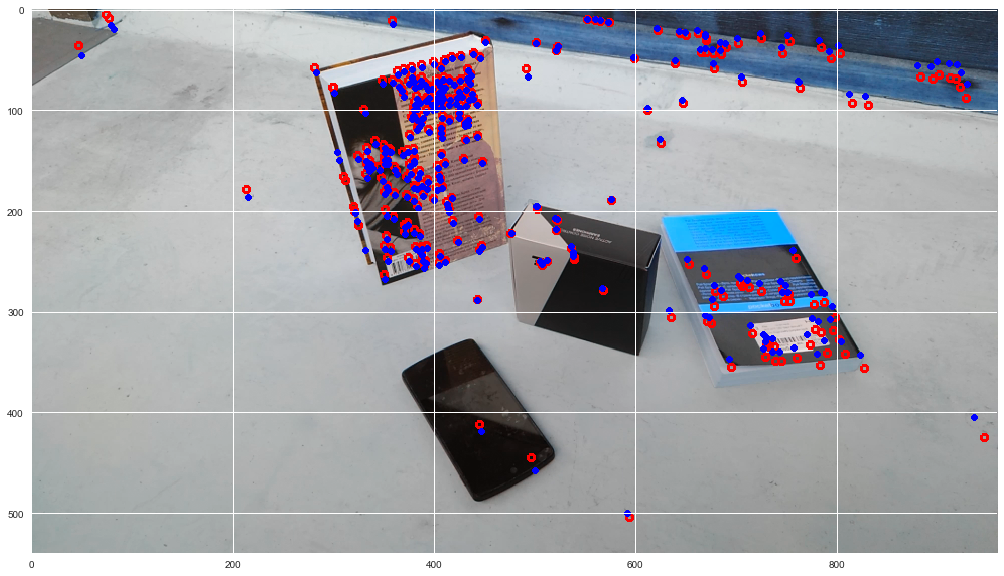

In [599]:
for point in camera1.project(points_3d):
    try:
        x, y = point[0]
        cv2.circle(img1, (int(x), int(y)), 3, (255, 0, 0), thickness=2, lineType=8, shift=0)
    except Exception as e:
        print(e)
    
for point in features_1.points:
    try:
        x, y = point[0]
        cv2.circle(img1, (int(x), int(y)), 2, (0, 0, 255), thickness=2, lineType=8, shift=0)
    except Exception as e:
        print(e)


plt.figure(figsize=(20,10))
plt.imshow(img1)

In [587]:
from src.utils.cube import generate_cube
cube = generate_cube(1.0, [0,0,10])

In [588]:
orb = cv2.ORB_create()

kp2, des2 = orb.detectAndCompute( buffer[60], None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(features_1.descriptors, des2)

pts2 = np.float64([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

_, R_recovered, t_recovered, _ = cv2.solvePnPRansac(points_3d.reshape(323, 3), pts2, Camera().K, Camera().distortion)


error: /Users/travis/build/skvark/opencv-python/opencv/modules/features2d/src/matchers.cpp:744: error: (-215) _queryDescriptors.type() == trainDescType in function knnMatchImpl


In [559]:
matches.shape

AttributeError: 'list' object has no attribute 'shape'

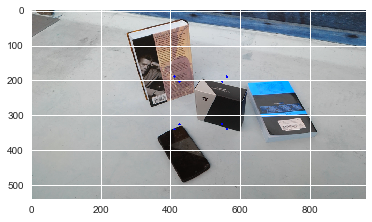

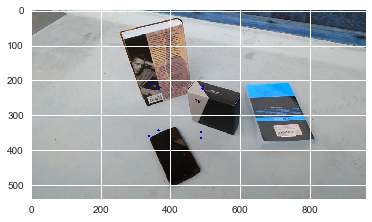

In [548]:
for point in camera1.project(cube):
    try:
        x, y = point[0]
        cv2.circle(buffer[4], (int(x), int(y)), 2, (0, 0, 255), thickness=2, lineType=8, shift=0)
    except Exception as e:
        print(e)
        
plt.imshow(buffer[4])
plt.show()

for point in camera2.project(cube):
    try:
        x, y = point[0]
        cv2.circle(buffer[32], (int(x), int(y)), 2, (0, 0, 255), thickness=2, lineType=8, shift=0)
    except Exception as e:
        print(e)
        
plt.imshow(buffer[32])
plt.show()

In [542]:
def reprojection_distance(input, points_3d, points_2d):
    r1, r2, r3, t1, t2, t3 = input[0], input[1], input[2], input[3], input[4], input[5]
    R = cv2.Rodrigues(np.array([r1, r2, r3]))[0]
    t = np.array([[t1], [t2], [t3]])
    camera = Camera()
    projected = cv2.projectPoints(
        points_3d,
        R,
        t,
        camera.K,
        camera.distortion
    )[0]
    vec1 = projected.reshape(projected.shape[0]*2)
    vec2 = points_2d.reshape(points_2d.shape[0]*2)
    res = 0
    for v1, v2 in zip(vec1, vec2):
        res += pow(v1 - v2, 2)

    return res


In [543]:
from scipy.optimize import minimize, rosen, rosen_der, basinhopping, fmin, fmin_cg, differential_evolution


In [544]:
# mystic
from mystic.penalty import quadratic_inequality
from mystic.solvers import diffev2
from mystic.monitors import VerboseMonitor

In [545]:
from dlt import DLTcalib, project


In [546]:
# upper
tmp_rod = cv2.Rodrigues(np.eye(3, 3))[0]
tmp_tvec = np.zeros((3, 1))
upper = [
    tmp_rod[0],
    tmp_rod[1],
    tmp_rod[2],
    tmp_tvec[0],
    tmp_tvec[1],
    tmp_tvec[2]  
]
# lower
tmp_rod = cv2.Rodrigues(R)[0]
tmp_tvec = t
initial = [
    tmp_rod[0],
    tmp_rod[1],
    tmp_rod[2],
    tmp_tvec[0],
    tmp_tvec[1],
    tmp_tvec[2]  
]
initial = [x[0] for x in initial]
upbound = [x*1.5 for x in initial]
lbound = [x*0.5 for x in initial]
bnds = [(x, y) for x, y in zip(upbound, lbound)]


In [547]:
frame_range = buffer[:30]
temp_images = []
for frame in frame_range:
    orb = cv2.ORB_create()

    kp2, des2 = orb.detectAndCompute(frame, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(features_1.descriptors, des2)

    pts2 = np.float64([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    

    
    mon = VerboseMonitor(100)
    result2 = diffev2(
        reprojection_distance, 
        x0=bnds, 
        args=(points_3d, pts2),
        npop=4, 
        gtol=200,
        disp=False, 
        full_output=True, 
        itermon=mon, 
        maxiter=300
    )
    
    qwe = result2[0]
    r1, r2, r3, t1, t2, t3 = qwe[0], qwe[1], qwe[2], qwe[3], qwe[4], qwe[5]
    
    
    R_recovered = cv2.Rodrigues(np.array([r1, r2, r3]))[0]
    t_recovered = np.array([[t1], [t2], [t3]])
    
    projective_camera = Camera.create(R_recovered, t_recovered)
    
    for point in projective_camera.project(cube):
        try:
            x, y = point[0]
            #print(x, y)
            cv2.circle(frame, (int(x), int(y)), 2, (0, 255, 0), thickness=2, lineType=8, shift=0)
        except Exception as e:
            print(e)

    temp_images.append(frame)
            

IndexError: index 1 is out of bounds for axis 0 with size 1

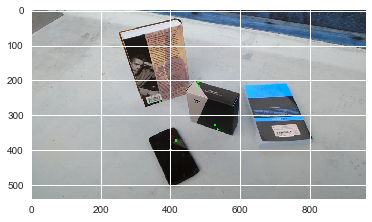

In [501]:
for i, image in enumerate(temp_images):
    plt.imshow(image)
    plt.savefig("saved_images/"+("%03d" % i)+'.png', bbox_inches='tight')
    #plt.show()